In [ ]:
"""
CS410 FA25 Group 18 Final Project

Install dependencies and make sure dataset exists
"""
# !pip install rank_bm25 sentence_transformers -q
# !python -m spacy download en_core_web_sm -q

# import os
# os.makedirs('data', exist_ok=True)

print('done')

'\nCS410 FA25 Group 18 Final Project\n\nInstall dependencies and make sure dataset exists\n'

In [49]:
import re
import nltk
import spacy
import numpy as np
import pandas as pd
import torch
import math

from tqdm import tqdm
from nltk.corpus import stopwords
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer, util
from collections import Counter

nltk.download('stopwords', quiet=True)

# global settings
STOPWORDS = set(stopwords.words('english'))
KEEP_WORDS = {'not', 'no', 'never', 'without', 'none'}
STOPWORDS = STOPWORDS - KEEP_WORDS

nlp = spacy.load('en_core_web_sm', disable=["parser"])

# preprocessing helpers
def clean_text(text, preserve_entities=True):
    text = str(text).lower()
    text = re.sub(r'[\\,<>./?@#$%^&*_~!()\-=\[\]{};:\'\"\|`0-9]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    doc = nlp(text)
    tokens = []
    for token in doc:
        if preserve_entities and token.ent_type_:
            tokens.append(token.text)
        elif token.lemma_ not in STOPWORDS and len(token.text) > 2:
            tokens.append(token.lemma_)
    return " ".join(tokens)

def normalize_title(t):
    return re.sub(r'[^a-z0-9\s]', '', str(t).lower().strip())

# load dataset from data directory
df = pd.read_csv("data/imdb_movie_keyword.csv")
print(f"Loaded {len(df)} movies")
df.head()

Loaded 9746 movies


,movie_title,year,genre,synopsis,cast,Key-Bert,Yake,Sentence_transformers
0,A Splash of Love,2022,"Comedy, Romance, Back to top","Chloe Turner, a Ph.D. candidate in Marine Mamm...","Heather Hawthorn Doyle (dir.), Rhiannon Fish, ...","['whale', 'miami', 'fish', 'pacific', 'marine']","['Miami Central College', 'Central College', '...","['chloe', 'turner', 'help', 'northwest', 'loca..."
1,The Grey Man,2007,"Biography, Crime, Drama, Back to top",Kevin Dodds is a browbeaten deputy bank manage...,"Declan O'Dwyer (dir.), Daniel Ryan, Nitin Ganatra","['rob', 'manager', 'bank', 'novel', 'devises']","['Kevin Dodds', 'browbeaten deputy bank', 'dep...","['bank', 'mcnab']"
2,Descendants,2015,"Comedy, Family, Fantasy, Back to top","Ben, son of Belle and the once selfish Beast, ...","Kenny Ortega (dir.), Dove Cameron, Cameron Boyce","['son', 'selfish', 'villain', 'beast', 'lost']","['attend Auradon Prep', 'Auradon Prep', 'son o...",['ben']
3,Teen Wolf: The Movie,n,"Action, Comedy, Drama, Back to top","A full moon rises in Beacon Hills, and with it...","Russell Mulcahy (dir.), Melissa Ponzio, Linden...","['werewolf', 'wolves', 'howling', 'deadliest',...","['full moon rises', 'Beacon Hills', 'rises in ...","['moon rises', 'trusted', 'werecoyotes']"
4,High School Musical,2006,"Comedy, Drama, Family, Back to top",Troy Bolton and Gabriella Montez are two total...,"Kenny Ortega (dir.), Zac Efron, Vanessa Hudgens","['decathlon', 'karaoke', 'mexico', 'party', 'a...","['Year Eve', 'Gabriella Montez', 'Troy Bolton'...","['troy', 'gabriella', 'hate', 'bolton', 'week'..."


In [50]:
# Process each field separately for BM25F-style scoring
df['plot_clean'] = df['synopsis'].apply(lambda x: clean_text(str(x)))
df['keywords_clean'] = df.apply(
    lambda r: clean_text(f"{r.get('Key-Bert', '')} {r.get('Yake', '')} {r.get('Sentence_transformers', '')}"), 
    axis=1
)
df['meta_clean'] = df.apply(
    lambda r: clean_text(f"{r.get('genre', '')} {r.get('year', '')}"), 
    axis=1
)

# Combined text for semantic embeddings
df['full_text'] = df['plot_clean'] + ' ' + df['keywords_clean'] + ' ' + df['meta_clean']

# Tokenized corpussss for each field
corpus_plot = [doc.split() for doc in df['plot_clean']]
corpus_keywords = [doc.split() for doc in df['keywords_clean']]
corpus_meta = [doc.split() for doc in df['meta_clean']]
corpus_full = [doc.split() for doc in df['full_text']]

print(f"Preprocessing complete. Sample plot: {df['plot_clean'].iloc[0][:100]}...")

Preprocessing complete. Sample plot: chloe turner candidate marine mammalogy miami central college get opportunity one week research proj...


In [51]:
# Build BM25 indices and semantic model
print("Building BM25 indices...")
bm25_plot = BM25Okapi(corpus_plot, k1=1.2, b=0.75)
bm25_keywords = BM25Okapi(corpus_keywords, k1=1.2, b=0.75)
bm25_meta = BM25Okapi(corpus_meta, k1=1.2, b=0.75)
bm25_full = BM25Okapi(corpus_full, k1=1.2, b=0.75)

print("Loading semantic model...")
semantic_model = SentenceTransformer("all-MiniLM-L6-v2")

print("Computing embeddings...")
embeddings = semantic_model.encode(df['full_text'].tolist(), convert_to_tensor=True, show_progress_bar=True)
print(f"Embeddings shape: {embeddings.shape}")

Building BM25 indices...
Loading semantic model...
Computing embeddings...


Batches:   0%|          | 0/305 [00:00<?, ?it/s]

Embeddings shape: torch.Size([9746, 384])


In [56]:
# BM25F-style scoring with field weights
def bm25f_score(query, w_plot=0.6, w_kw=0.3, w_meta=0.1):
    """Compute weighted BM25 scores across fields."""
    q_tokens = clean_text(query).split()
    scores_plot = bm25_plot.get_scores(q_tokens)
    scores_kw = bm25_keywords.get_scores(q_tokens)
    scores_meta = bm25_meta.get_scores(q_tokens)
    return w_plot * scores_plot + w_kw * scores_kw + w_meta * scores_meta

def get_top_k_bm25(query, top_k=200):
    """Stage 1: BM25F retrieval."""
    scores = bm25f_score(query)
    top_idx = np.argsort(scores)[::-1][:top_k].copy()
    return top_idx, scores[top_idx]

In [61]:
# Pseudo-Relevance Feedback (PRF)
def compute_idf(corpus):
    """Compute IDF for PRF term expansion."""
    N = len(corpus)
    df_counts = Counter()
    for doc in corpus:
        df_counts.update(set(doc))
    return {term: math.log((N + 1) / (count + 1)) for term, count in df_counts.items()}

idf_scores = compute_idf(corpus_full)

def expand_query_prf(query, top_docs_idx, n_terms=10, prf_weight=0.3):
    """Expand query using pseudo-relevance feedback."""
    term_scores = Counter()
    for idx in top_docs_idx:
        doc_terms = corpus_full[idx]
        tf = Counter(doc_terms)
        for term, count in tf.items():
            if term in idf_scores:
                term_scores[term] += count * idf_scores[term]
    
    original_terms = set(clean_text(query).split())
    expansion_terms = [t for t, _ in term_scores.most_common(n_terms + len(original_terms)) 
                      if t not in original_terms][:n_terms]
    
    expanded = clean_text(query) + ' ' + ' '.join([f"{t}" for t in expansion_terms])
    return expanded

In [62]:
# Two-Stage Hybrid Search
def normalize_scores(scores):
    """Min-max normalize scores."""
    min_s, max_s = scores.min(), scores.max()
    if max_s - min_s < 1e-9:
        return np.zeros_like(scores)
    return (scores - min_s) / (max_s - min_s)

def two_stage_search(query, alpha=0.65, stage1_k=200, top_k=10, use_prf=True, prf_docs=10):
    """
    Two-stage retrieval:
    Stage 1: BM25F retrieves top-K candidates
    Stage 2: Semantic reranking on candidates
    """
    q_clean = clean_text(query)
    
    if use_prf:
        initial_idx, _ = get_top_k_bm25(query, top_k=prf_docs)
        q_expanded = expand_query_prf(query, initial_idx)
    else:
        q_expanded = q_clean
    
    # BM25F scoring
    bm25_scores = bm25f_score(q_expanded if use_prf else query)
    candidate_idx = np.argsort(bm25_scores)[::-1][:stage1_k].copy()
    
    # Stage 2: Semantic reranking on candidates only
    candidate_embeddings = embeddings[candidate_idx]
    q_emb = semantic_model.encode(q_clean, convert_to_tensor=True)
    sem_scores = util.cos_sim(q_emb, candidate_embeddings)[0].cpu().numpy()
    
    # Normalize and combine
    bm25_norm = normalize_scores(bm25_scores[candidate_idx])
    sem_norm = normalize_scores(sem_scores)
    hybrid_scores = alpha * sem_norm + (1 - alpha) * bm25_norm
    
    # Get top-k from candidates
    top_in_candidates = np.argsort(hybrid_scores)[::-1][:top_k].copy()
    final_idx = candidate_idx[top_in_candidates]
    final_scores = hybrid_scores[top_in_candidates]
    
    return final_idx, final_scores

In [63]:
import json

# load test queries for tuning
with open('test_queries.json', 'r') as f:
    test_queries = json.load(f)

print(test_queries)

[{'query': "Two teenagers meet at a New Year's Eve karaoke party and later discover they attend the same high school", 'relevant': {'High School Musical': 2}}, {'query': 'Basketball star and brainy new girl audition for school musical against drama queen siblings', 'relevant': {'High School Musical': 2}}, {'query': 'Marine biology PhD student studies endangered orca whales in Pacific Northwest', 'relevant': {'A Splash of Love': 2}}, {'query': 'Researcher falls for tour guide while studying Southern Resident orca population in Washington State', 'relevant': {'A Splash of Love': 2}}, {'query': 'Children of Disney villains from Isle of the Lost attend prestigious prep school', 'relevant': {'Descendants': 2}}, {'query': 'Son of Belle and Beast invites villain kids to Auradon Prep school', 'relevant': {'Descendants': 2}}, {'query': 'Alpha werewolf returns to Beacon Hills to gather supernatural allies against deadly threat', 'relevant': {'Teen Wolf: The Movie': 2}}, {'query': 'Banshees werec

In [64]:
# Hyperparameter tuning for best ndcg@10
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)



# Evaluation metrics
def precision_at_k(relevance, k=10):
    """Calculate precision@k from relevance scores."""
    relevance = np.asarray(relevance)[:k]
    return np.sum(relevance > 0) / k

def ndcg_at_k(relevance, k=10):
    """Calculate nDCG@k from relevance scores."""
    relevance = np.asarray(relevance)[:k]
    dcg = np.sum(relevance / np.log2(np.arange(2, len(relevance) + 2)))
    ideal = np.sum(sorted(relevance, reverse=True) / np.log2(np.arange(2, len(relevance) + 2)))
    return dcg / ideal if ideal > 0 else 0

def get_relevance_scores(retrieved_idx, relevant_dict):
    """Get relevance scores for retrieved documents."""
    rel_normalized = {normalize_title(k): v for k, v in relevant_dict.items()}
    scores = []
    for idx in retrieved_idx:
        title = normalize_title(df.iloc[idx]['movie_title'])
        scores.append(rel_normalized.get(title, 0))
    return scores

# Define search function with configurable parameters
def search_with_params(query, alpha, w_plot, w_kw, w_meta, stage1_k=200, top_k=10, use_prf=True, prf_docs=10):
    """Search with configurable hyperparameters."""
    q_clean = clean_text(query)
    q_tokens = q_clean.split()
    
    # BM25F scoring with custom weights
    scores_plot = bm25_plot.get_scores(q_tokens)
    scores_kw = bm25_keywords.get_scores(q_tokens)
    scores_meta = bm25_meta.get_scores(q_tokens)
    bm25_scores = w_plot * scores_plot + w_kw * scores_kw + w_meta * scores_meta
    
    if use_prf:
        initial_idx = np.argsort(bm25_scores)[::-1][:prf_docs].copy()
        q_expanded = expand_query_prf(query, initial_idx)
        q_tokens_expanded = q_expanded.split()
        scores_plot = bm25_plot.get_scores(q_tokens_expanded)
        scores_kw = bm25_keywords.get_scores(q_tokens_expanded)
        scores_meta = bm25_meta.get_scores(q_tokens_expanded)
        bm25_scores = w_plot * scores_plot + w_kw * scores_kw + w_meta * scores_meta
    
    candidate_idx = np.argsort(bm25_scores)[::-1][:stage1_k].copy()
    
    # Semantic reranking
    candidate_embeddings = embeddings[candidate_idx]
    q_emb = semantic_model.encode(q_clean, convert_to_tensor=True)
    sem_scores = util.cos_sim(q_emb, candidate_embeddings)[0].cpu().numpy()
    
    bm25_norm = normalize_scores(bm25_scores[candidate_idx])
    sem_norm = normalize_scores(sem_scores)
    hybrid_scores = alpha * sem_norm + (1 - alpha) * bm25_norm
    
    top_in_candidates = np.argsort(hybrid_scores)[::-1][:top_k].copy()
    return candidate_idx[top_in_candidates], hybrid_scores[top_in_candidates]

# Optuna objective function
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.4, 0.9)
    w_plot = trial.suggest_float('w_plot', 0.3, 0.7)
    w_kw = trial.suggest_float('w_kw', 0.1, 0.5)
    w_meta = 1.0 - w_plot - w_kw
    
    if w_meta < 0.05:  # Ensure minimum weight for metadata
        return 0.0
    
    ndcg_scores = []
    for q in test_queries:
        idx, _ = search_with_params(q['query'], alpha, w_plot, w_kw, w_meta, use_prf=True)
        rel = get_relevance_scores(idx, q['relevant'])
        ndcg_scores.append(ndcg_at_k(rel, 10))
    
    return np.mean(ndcg_scores)

# Run Optuna optimization
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=30, show_progress_bar=True)

# Get best parameters
best_params = study.best_params
best_params['w_meta'] = 1.0 - best_params['w_plot'] - best_params['w_kw']

print(f"\nBest parameters: {best_params}")
print(f"Best nDCG@10: {study.best_value:.4f}")

tuned_alpha = best_params['alpha']
tuned_w_plot = best_params['w_plot']
tuned_w_kw = best_params['w_kw']
tuned_w_meta = best_params['w_meta']

  0%|          | 0/30 [00:00<?, ?it/s]


Best parameters: {'alpha': 0.69503362452272, 'w_plot': 0.32645288763900704, 'w_kw': 0.12972990705525062, 'w_meta': 0.5438172053057424}
Best nDCG@10: 0.6552


In [65]:
# Save trained model components to models/ directory
import pickle
import os

os.makedirs('models', exist_ok=True)

# Use tuned parameters from hyperparameter search

model_config = {
    'alpha': tuned_alpha,
    'w_plot': tuned_w_plot,
    'w_kw': tuned_w_kw,
    'w_meta': tuned_w_meta,
    'stage1_k': 200,
    'use_prf': True,
    'prf_docs': 10,
    'prf_terms': 10
}

print("Saving model config...")
with open('models/model_config.pkl', 'wb') as f:
    pickle.dump(model_config, f)

print("Saving embeddings...")
torch.save(embeddings, 'models/embeddings.pt')

print("Saving IDF scores...")
with open('models/idf_scores.pkl', 'wb') as f:
    pickle.dump(idf_scores, f)

print(f"\nModel saved to models/ with config: {model_config}")

Saving model config...
Saving embeddings...
Saving IDF scores...

Model saved to models/ with config: {'alpha': 0.69503362452272, 'w_plot': 0.32645288763900704, 'w_kw': 0.12972990705525062, 'w_meta': 0.5438172053057424, 'stage1_k': 200, 'use_prf': True, 'prf_docs': 10, 'prf_terms': 10}


In [66]:
# Interactive search function for testing
def search(query, top_k=10):
    """Production search function."""
    idx, scores = two_stage_search(query, alpha=alpha, stage1_k=200, top_k=top_k, use_prf=True)
    results = df.iloc[idx][['movie_title', 'genre', 'synopsis']].copy()
    results['score'] = scores
    return results

# quick test
test_queries = [
    "teenagers singing at school musical",
    "werewolf supernatural Beacon Hills",
    "marine biologist studies whales"
]

for q in test_queries:
    print(f"\nQuery: {q}")
    print(f"Top relevant: {list(search(q, top_k=5)['movie_title'])}")


Query: teenagers singing at school musical
Top relevant: ['High School Musical', 'Winter Dragon', 'Zombie Night', 'Der Wettbewerb', 'Friend Request']

Query: werewolf supernatural Beacon Hills
Top relevant: ['Teen Wolf: The Movie', 'Ghost Shark', 'An Adventure in Space and Time', 'I Dream of Jeannie... Fifteen Years Later', '12 Tage Sommer']

Query: marine biologist studies whales
Top relevant: ['Demon and the Mummy', "The Rocky Horror Picture Show: Let's Do the Time Warp Again", 'A Splash of Love', 'The Sweetest Heart', 'Clapham Junction']


In [70]:
# Evaluation: Compare Baseline (BM25) vs Full Model (2-stage + BM25F + PRF)

# Define search methods for comparison
def search_baseline_bm25(query, top_k=10):
    """Baseline: BM25 only (no semantic reranking)."""
    q_tokens = clean_text(query).split()
    scores = bm25_full.get_scores(q_tokens)
    top_idx = np.argsort(scores)[::-1][:top_k].copy()
    return top_idx, scores[top_idx]

def search_full_model(query, alpha=None, w_plot=None, w_kw=None, w_meta=None, top_k=10):
    """Full model: 2-stage + BM25F + PRF with tuned parameters."""
    _alpha = alpha if alpha is not None else tuned_alpha
    _w_plot = w_plot if w_plot is not None else tuned_w_plot
    _w_kw = w_kw if w_kw is not None else tuned_w_kw
    _w_meta = w_meta if w_meta is not None else tuned_w_meta
    
    return search_with_params(query, _alpha, _w_plot, _w_kw, _w_meta, use_prf=True, top_k=top_k)

# Evaluate all methods
def evaluate_method(search_fn, queries, method_name):
    """Evaluate a search method on the query set."""
    ndcg_scores = []
    prec_scores = []
    
    for q in tqdm(queries, desc=f"Evaluating {method_name}"):
        idx, _ = search_fn(q['query'])
        rel = get_relevance_scores(idx, q['relevant'])
        ndcg_scores.append(ndcg_at_k(rel, 10))
        prec_scores.append(precision_at_k(rel, 10))
    
    return {
        'method': method_name,
        'ndcg@10': np.mean(ndcg_scores),
        'p@10': np.mean(prec_scores),
        'ndcg_std': np.std(ndcg_scores),
        'prec_std': np.std(prec_scores)
    }

print("Evaluating search methods...")
print("=" * 60)

# Run evaluation
eval_results = []

# 1. Baseline BM25
result_bm25 = evaluate_method(search_baseline_bm25, query_set, "Baseline (BM25)")
eval_results.append(result_bm25)
print(f"Baseline (BM25): nDCG@10={result_bm25['ndcg@10']:.4f}, P@10={result_bm25['p@10']:.4f}")

# 2. Full model (2-stage + BM25F + PRF)
result_full = evaluate_method(search_full_model, query_set, "Full Model")
eval_results.append(result_full)
print(f"Full Model: nDCG@10={result_full['ndcg@10']:.4f}, P@10={result_full['p@10']:.4f}")

print("=" * 60)

# Create results DataFrame
results_df = pd.DataFrame(eval_results)
print("\nEvaluation Results Summary:")
print(results_df.to_string(index=False))

Evaluating search methods...


Evaluating Baseline (BM25): 100%|██████████| 100/100 [00:02<00:00, 33.63it/s]


Baseline (BM25): nDCG@10=0.6717, P@10=0.0700


Evaluating Full Model: 100%|██████████| 100/100 [00:16<00:00,  5.96it/s]

Full Model: nDCG@10=0.6552, P@10=0.0700

Evaluation Results Summary:
         method  ndcg@10  p@10  ndcg_std  prec_std
Baseline (BM25) 0.671725  0.07  0.454769  0.045826
     Full Model 0.655173  0.07  0.449882  0.045826


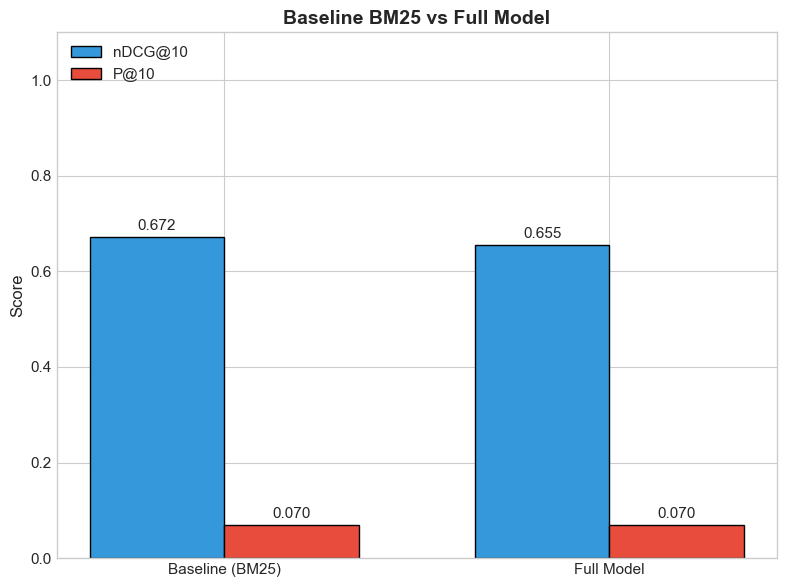


Improvement over Baseline (BM25):
  Full Model: nDCG -2.5%, P@10 +0.0%


In [72]:
# Plot evaluation results as bar graph
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))

methods = [r['method'] for r in eval_results]
ndcg_scores = [r['ndcg@10'] for r in eval_results]
prec_scores = [r['p@10'] for r in eval_results]

x = np.arange(len(methods))
width = 0.35

bars1 = ax.bar(x - width/2, ndcg_scores, width, label='nDCG@10', color='#3498db', edgecolor='black')
bars2 = ax.bar(x + width/2, prec_scores, width, label='P@10', color='#e74c3c', edgecolor='black')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Baseline BM25 vs Full Model', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods, fontsize=11)
ax.legend(loc='upper left')
ax.set_ylim(0, 1.1)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=11)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

# Print improvement summary
print("\nImprovement over Baseline (BM25):")
baseline_ndcg = eval_results[0]['ndcg@10']
baseline_prec = eval_results[0]['p@10']

r = eval_results[1]
ndcg_imp = ((r['ndcg@10'] - baseline_ndcg) / baseline_ndcg * 100) if baseline_ndcg > 0 else 0
prec_imp = ((r['p@10'] - baseline_prec) / baseline_prec * 100) if baseline_prec > 0 else 0
print(f"  {r['method']}: nDCG {ndcg_imp:+.1f}%, P@10 {prec_imp:+.1f}%")